In [30]:
import importlib
import pandas as pd
import utils

In [31]:
importlib.reload(utils)

<module 'utils' from '/Users/nicolearitranair/ml-basics/notebook/utils.py'>

In [95]:
import numpy as np

df = utils.get_product_recommendation_data()
df

,user,item,rating
0,1,MSPP02,3
4,1,UPPP01,3
5,1,VSPP25,2
6,1,MSGT91,1
7,1,VSPP33,2
...,...,...,...
123989,1000,MSGT31,2
123991,1000,MSGT32,2
123994,1000,MSGT47,3
123997,1000,MSGT19,1


In [96]:
df.to_csv("output_data/product-recommendation.csv")

# Split into train and test

In [97]:
idx = df.sample(frac=0.5, random_state=12345).index
train_df = df.drop(idx, inplace=False)
test_df = df.loc[idx]

In [98]:
train_df

,user,item,rating
6,1,MSGT91,1
7,1,VSPP33,2
11,1,VSSS09,2
13,1,VSSS01,3
16,1,MSGT66,2
...,...,...,...
123975,1000,MSGT44,2
123987,1000,MSGT15,2
123989,1000,MSGT31,2
123994,1000,MSGT47,3


In [99]:
from fastai.tabular.all import *
from fastai.collab import *

dls = CollabDataLoaders.from_df(train_df,  bs=64)

dls.show_batch()

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

learn.fit_one_cycle(5, 5e-3, wd=0.1)

g = train_df.groupby('item')['rating'].count()

,user,item,rating
0,388,MSCA47,3
1,781,MSGT12,1
2,847,MSPP02,3
3,979,VSPP05,2
4,901,MSGT30,2
5,16,JCGA75,1
6,902,VCBGSC,2
7,438,VSPP29,1
8,844,MSGT43,2
9,530,MSGT28,2


epoch,train_loss,valid_loss,time
0,0.265915,0.204619,00:02
1,0.125706,0.151516,00:02
2,0.072529,0.133052,00:02
3,0.050426,0.120607,00:02
4,0.045228,0.117521,00:02


In [100]:
items = train_df["item"].unique()

item_bias = learn.model.bias(items, is_item=True)
item_bias.shape

mean_ratings = train_df.groupby('item')['rating'].mean()
item_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(items,item_bias)]

Check movies with the worst ratings.

In [101]:
item0 = lambda o:o[0]
sorted(item_ratings, key=item0)[:15]

[(tensor(-0.7456), 'VSPP37', np.float64(1.004)),
 (tensor(-0.7148), 'VSPP17', np.float64(1.0114503816793894)),
 (tensor(-0.7085), 'MRLP02', np.float64(1.0111524163568772)),
 (tensor(-0.5236), 'JCGA70', np.float64(1.1428571428571428)),
 (tensor(-0.5179), 'CIS02', np.float64(1.1946902654867257)),
 (tensor(-0.4906), 'MSGT65', np.float64(1.1647058823529413)),
 (tensor(-0.4755), 'MSGT52', np.float64(1.2307692307692308)),
 (tensor(-0.4740), 'VSPP33', np.float64(1.2419354838709677)),
 (tensor(-0.4739), 'VSPP29', np.float64(1.20817843866171)),
 (tensor(-0.4536), 'MSGT91', np.float64(1.2530120481927711)),
 (tensor(-0.4517), 'MSGT02', np.float64(1.2608695652173914)),
 (tensor(-0.4393), 'VSCA25', np.float64(1.3389830508474576)),
 (tensor(-0.4359), 'MSGT62', np.float64(1.2657657657657657)),
 (tensor(-0.4143), 'MSGT55', np.float64(1.3378995433789955)),
 (tensor(-0.4039), 'MRLP07', np.float64(1.3412698412698412))]

In [102]:
sorted(item_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.2443), 'VSSS06', np.float64(2.748987854251012)),
 (tensor(0.1773), 'MRLP01', np.float64(2.623481781376518)),
 (tensor(0.1324), 'VSSS04', np.float64(2.561181434599156)),
 (tensor(0.1283), 'MSGT07', np.float64(2.5019607843137255)),
 (tensor(0.0815), 'MSGT33', np.float64(2.432)),
 (tensor(0.0604), 'MSWR07', np.float64(2.413793103448276)),
 (tensor(0.0591), 'VCGA63', np.float64(2.4273858921161824)),
 (tensor(0.0416), 'MSGT21', np.float64(2.376)),
 (tensor(0.0413), 'VSPP23', np.float64(2.456896551724138)),
 (tensor(0.0329), 'MSWW04', np.float64(2.3492063492063493)),
 (tensor(0.0295), 'MSWR01', np.float64(2.416)),
 (tensor(0.0288), 'MSCA47', np.float64(2.3254901960784315)),
 (tensor(0.0227), 'MSWR05', np.float64(2.254612546125461)),
 (tensor(0.0203), 'CIS04', np.float64(2.2283464566929134)),
 (tensor(0.0200), 'MSGT04', np.float64(2.393162393162393))]

Analyzing the latent factors that our model has learned

In [103]:
item_w = learn.model.weight(items, is_item=True)
item_w.shape

torch.Size([124, 50])

PCA for visualization

In [104]:
item_pca = item_w.pca(3)
item_pca.shape

torch.Size([124, 3])

In [105]:
fac0,fac1,fac2 = item_pca.t()
item_comp = [(f, i) for f,i in zip(fac0, items)]

In [106]:
sorted(item_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3753), 'MRLP02'),
 (tensor(1.3196), 'VSPP37'),
 (tensor(1.3043), 'VSPP17'),
 (tensor(1.0127), 'JCGA70'),
 (tensor(0.8937), 'CIS02'),
 (tensor(0.8510), 'MSGT65'),
 (tensor(0.7238), 'MSGT19'),
 (tensor(0.6394), 'MSGT55'),
 (tensor(0.6192), 'VIGI01'),
 (tensor(0.6131), 'MSGT91')]

In [107]:
sorted(item_comp, key=itemgetter(0))[:10]

[(tensor(-0.8973), 'VSSS06'),
 (tensor(-0.8364), 'MSWR01'),
 (tensor(-0.7525), 'CIS04'),
 (tensor(-0.7503), 'VSSS04'),
 (tensor(-0.7430), 'MRLP01'),
 (tensor(-0.7218), 'MSGT04'),
 (tensor(-0.7105), 'MSGT33'),
 (tensor(-0.7073), 'MSWR07'),
 (tensor(-0.7031), 'MSCA47'),
 (tensor(-0.6681), 'UPPP01')]

In [108]:
item_comp = [(f, i) for f,i in zip(fac1, items)]
sorted(item_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9984), 'VIGI01'),
 (tensor(0.8950), 'VSPP09'),
 (tensor(0.7916), 'MSGT43'),
 (tensor(0.7829), 'MSGT14'),
 (tensor(0.7651), 'VSPP15'),
 (tensor(0.6788), 'VSPP20'),
 (tensor(0.6749), 'MSPP03'),
 (tensor(0.6068), 'MSGT05'),
 (tensor(0.5461), 'MSGT10'),
 (tensor(0.5261), 'VSPP03')]

In [109]:
sorted(item_comp, key=itemgetter(0))[:10]

[(tensor(-0.6691), 'MSGT25'),
 (tensor(-0.6145), 'MSGT90'),
 (tensor(-0.5883), 'MSGT28'),
 (tensor(-0.5652), 'VSPP02'),
 (tensor(-0.5530), 'MSPP10'),
 (tensor(-0.5272), 'MSGT68'),
 (tensor(-0.5268), 'MSGT52'),
 (tensor(-0.5180), 'URLP07'),
 (tensor(-0.5155), 'MSGT31'),
 (tensor(-0.5054), 'MSGT20')]

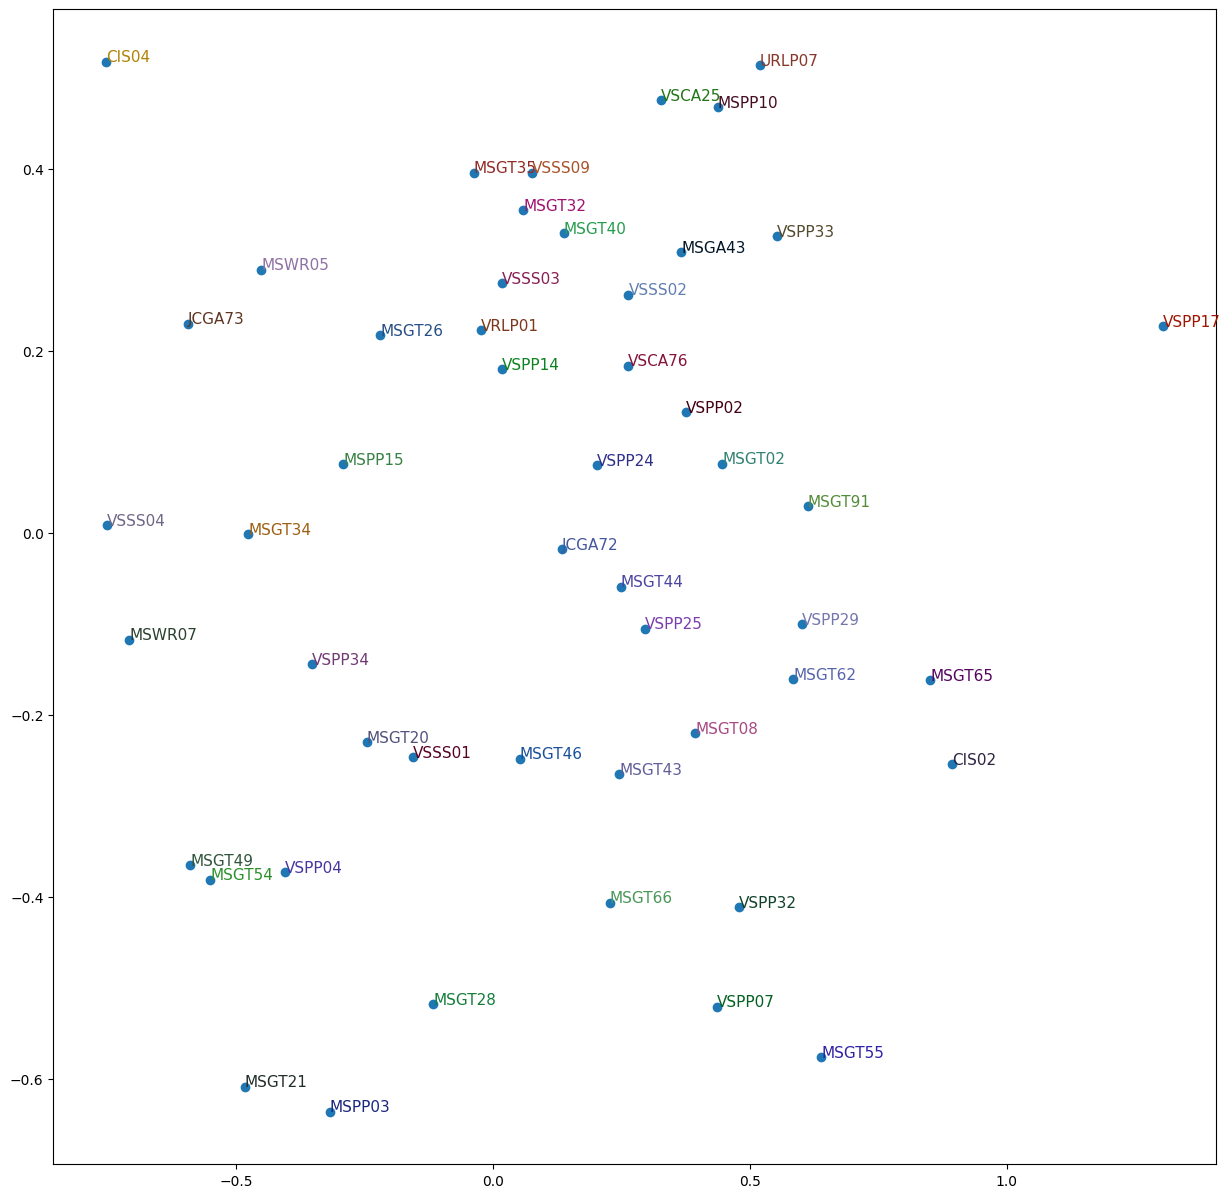

In [110]:
import matplotlib.pyplot as plt

idxs = np.random.choice(len(items), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(items[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Demonstrate selecting products to recommend for a single user

We select the top 5 recommended items for the user 1

In [166]:
unknown_ratings_for_user_1 = test_df.iloc[:,:-1][test_df["user"] == 1]

In [174]:
row = learn.dls.test_dl(unknown_ratings_for_user_1)

top_k_indices = learn.get_preds(dl=row)[0].topk(5).indices.numpy()

print("Top 5 recommended products for user 1: ")
print(unknown_ratings_for_user_1["item"].iloc[top_k_indices])


Top 5 recommended products for user 1: 
82     MSGT24
90     MSGT54
106    MSWW04
0      MSPP02
60     VSPP11
Name: item, dtype: object


# Test rating prediction RMSE on test data (i.e. for items that have not yet been used by the users)

In [146]:
row = learn.dls.test_dl(test_df.iloc[:,:-1])

pred = learn.get_preds(dl=row)[0].numpy()

# Calculate RMSE

In [150]:
np.sqrt(np.mean((test_df["rating"] - pred)**2))

np.float64(0.3465933684593938)